# EDA RON-MON

## Librerías

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Carga de datos

In [2]:
df = pd.read_excel("Dataset.xlsx")
df.head()

,IDENT.,3931 cm-1,3933 cm-1,3934 cm-1,3936 cm-1,3938 cm-1,3940 cm-1,3942 cm-1,3944 cm-1,3946 cm-1,...,4743 cm-1,4745 cm-1,4746 cm-1,4748 cm-1,4750 cm-1,4752 cm-1,4754 cm-1,4756 cm-1,RON,MON
0,1901200369,0.326916,0.328183,0.331196,0.333116,0.333588,0.333005,0.331655,0.332033,0.332783,...,0.113454,0.113044,0.112669,0.112353,0.112096,0.111832,0.111593,0.111406,86.9,80.1
1,1901270017,0.326238,0.327581,0.330556,0.332406,0.332884,0.332398,0.331201,0.331619,0.332341,...,0.113065,0.112715,0.112354,0.111964,0.111656,0.111444,0.111207,0.110981,86.2,79.1
2,1901310027,0.330758,0.332153,0.335328,0.337357,0.337954,0.337500,0.336280,0.336734,0.337453,...,0.114583,0.114021,0.113539,0.113071,0.112623,0.112270,0.111935,0.111583,89.5,79.8
3,1902020388,0.330447,0.331509,0.332713,0.333581,0.334030,0.334060,0.333881,0.333889,0.334073,...,0.113781,0.113383,0.112989,0.112656,0.112399,0.112175,0.111936,0.111711,86.6,78.9
4,1902050030,0.327479,0.328504,0.329894,0.330900,0.331401,0.331470,0.331336,0.331551,0.331906,...,0.114061,0.113693,0.113330,0.113005,0.112726,0.112484,0.112223,0.112008,85.9,78.7


## Inspección inicial:

El dataset corresponde a espectros NIR (infrarrojo cercano) de combustibles, donde:
* Cada columna como `3931 cm-1`, `3933 cm-1`, ..., `4756 cm-1` representa una longitud de onda (número de onda) y el valor asociado es la absorbancia o reflectancia medida en esa región del espectro.
* Las columnas finales `RON` y `MON` son las propiedades objetivo (valores de octanaje).
* La columna `IDENT` es sólo un identificador de muestra.

In [4]:
df.shape

(1168, 432)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Columns: 432 entries, IDENT. to MON
dtypes: float64(431), int64(1)
memory usage: 3.8 MB


## Identificación de columnas espectrales y objetivos:

Separar variables:

In [6]:
id_col = 'IDENT.'
target_cols = ['RON', 'MON']
spectral_cols = [col for col in df.columns if 'cm' in col]

Número de longitudes de onda:

In [7]:
print(f"Número de longitudes de onda: {len(spectral_cols)}")

Número de longitudes de onda: 429


Inspección de columnas objetivo:

In [8]:
df[target_cols].describe()

,RON,MON
count,1168.000000,1164.000000
mean,86.687449,78.565301
std,8.076438,5.687131
min,60.000000,58.800000
25%,86.200000,78.500000
50%,87.900000,79.600000
75%,90.925000,80.600000
max,97.800000,89.900000


## Revisión de valores daltantes o nulos:

In [9]:
df.isnull().sum().sum()

4

Interpolación de valores nulos:

In [12]:
df = df.interpolate(axis=1)

In [13]:
df.isnull().sum().sum()

0

## Visualización de espectros:

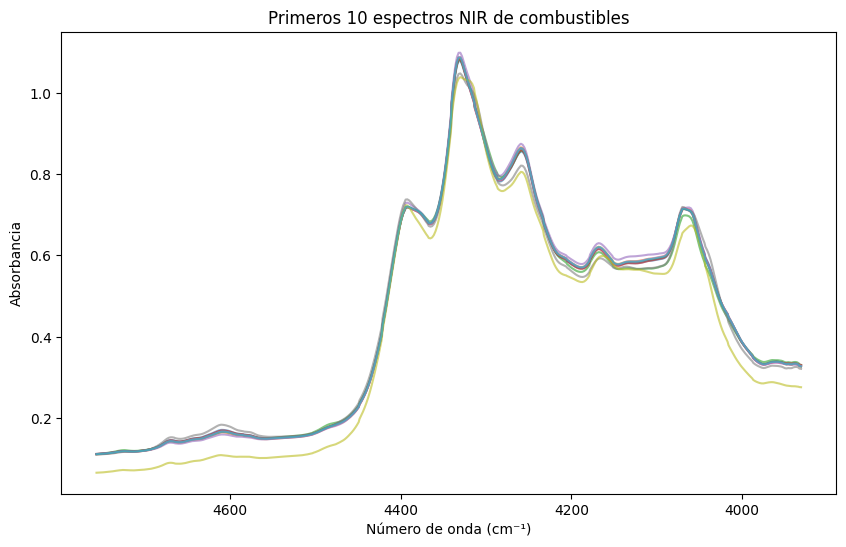

In [15]:
plt.figure(figsize=(10,6))
for i in range(10):  # primeros 10 espectros
    plt.plot([float(c.replace(' cm-1','')) for c in spectral_cols],
             df.loc[i, spectral_cols],
             alpha=0.6)
plt.title('Primeros 10 espectros NIR de combustibles')
plt.xlabel('Número de onda (cm⁻¹)')
plt.ylabel('Absorbancia')
plt.gca().invert_xaxis()  # usual en espectros NIR
plt.show()

## Distribución de RON y MON:

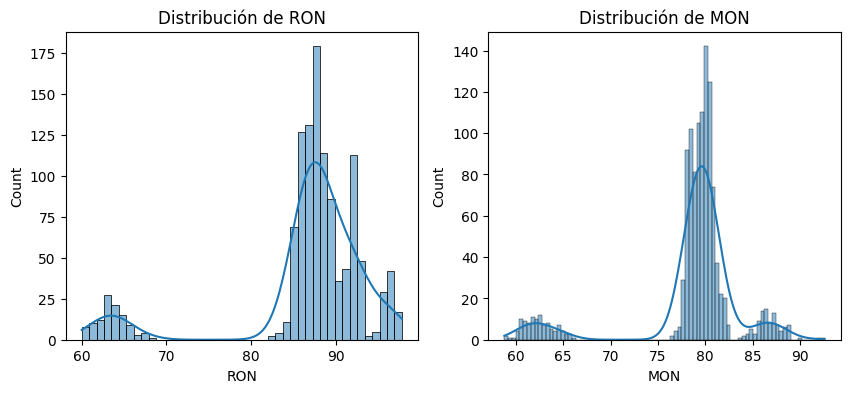

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.histplot(df['RON'], kde=True, ax=axes[0])
sns.histplot(df['MON'], kde=True, ax=axes[1])
axes[0].set_title('Distribución de RON')
axes[1].set_title('Distribución de MON')
plt.show()

## Relación entre RON y MON

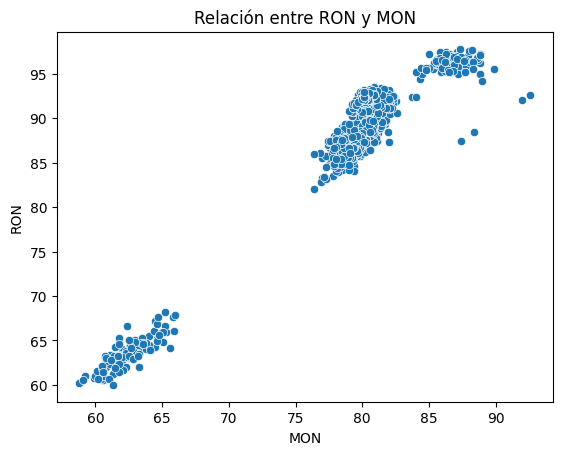

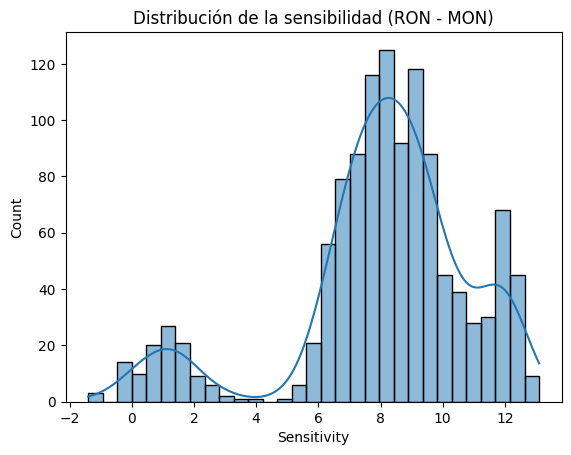

In [18]:
sns.scatterplot(x='MON', y='RON', data=df)
plt.title('Relación entre RON y MON')
plt.show()

df['Sensitivity'] = df['RON'] - df['MON']
sns.histplot(df['Sensitivity'], kde=True)
plt.title('Distribución de la sensibilidad (RON - MON)')
plt.show()

## Análisis de correlaciones entre longitudes de onda

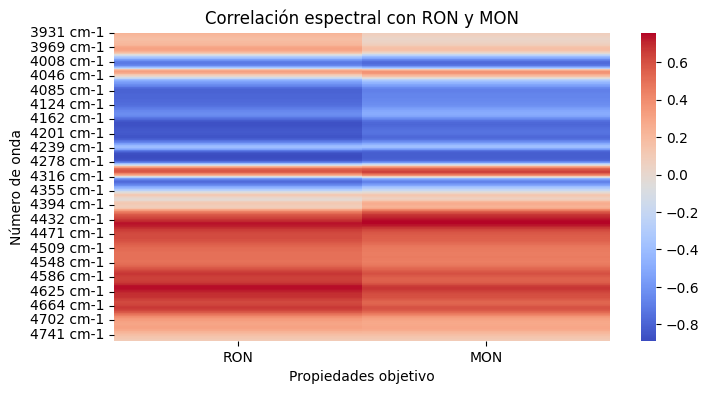

In [20]:
corr_matrix = df[spectral_cols + target_cols].corr()
plt.figure(figsize=(8,4))
sns.heatmap(corr_matrix[target_cols].iloc[:-2,:], cmap='coolwarm')
plt.title('Correlación espectral con RON y MON')
plt.xlabel('Propiedades objetivo')
plt.ylabel('Número de onda')
plt.show()

## Análisis de componentes principales (PCA)

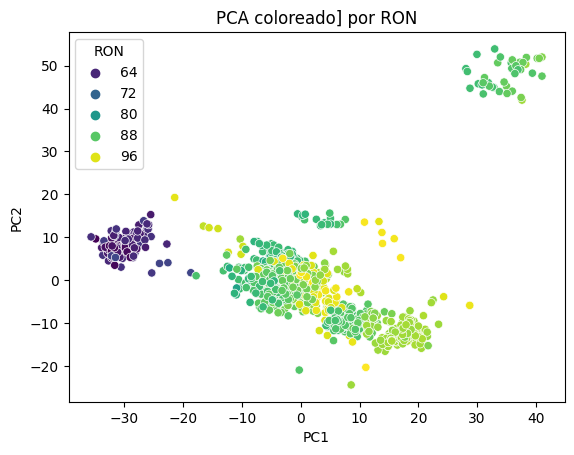

In [23]:
X = df[spectral_cols]
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['RON'], palette='viridis')
plt.title('PCA coloreado] por RON')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [24]:
print("Varianza explicada acumulada:", np.cumsum(pca.explained_variance_ratio_))

Varianza explicada acumulada: [0.46173039 0.78210752 0.93046285]


## Detección de outliers espectrales

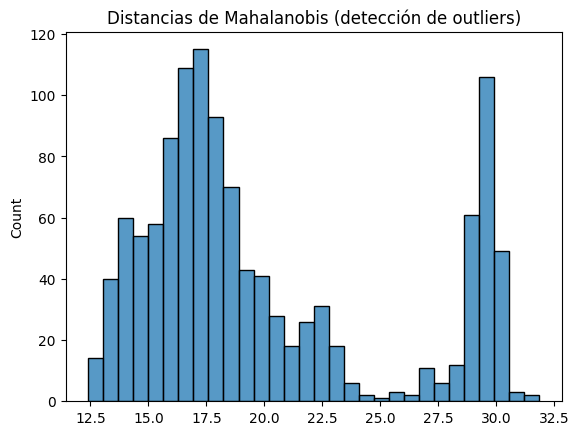

In [25]:
cov = np.cov(X_scaled, rowvar=False)
inv_cov = np.linalg.inv(cov)
mean = np.mean(X_scaled, axis=0)
mahal = [mahalanobis(x, mean, inv_cov) for x in X_scaled]

sns.histplot(mahal, bins=30)
plt.title('Distancias de Mahalanobis (detección de outliers)')
plt.show()